In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.impute import KNNImputer
from sklearn import preprocessing
# from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold as KF

from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostClassifier
import xgboost
import lightgbm as lgb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/playground-series-s3e20/sample_submission.csv
/kaggle/input/playground-series-s3e20/train.csv
/kaggle/input/playground-series-s3e20/test.csv


In [2]:
BASE_PATH = '/kaggle/input/playground-series-s3e20'
df_test = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
df_train = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
df_sample_sub = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

In [3]:
df_train.describe()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023.000000,79023.000000,79023.000000,79023.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,...,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,79023.000000
mean,-1.891072,29.880155,2020.000000,26.000000,0.000048,0.834848,0.000035,0.158418,-7.925870,37.436189,...,5592.377478,59420.297456,4670.430869,19.139241,0.271460,-10.784832,40.436976,-86.800583,27.925981,81.940552
std,0.694522,0.810375,0.816502,15.297155,0.000272,0.185382,0.000206,0.071364,64.263368,14.149950,...,1428.503002,9051.163609,1359.251583,13.547047,0.049434,30.374462,6.428216,37.837269,4.403835,144.299648
min,-3.299000,28.228000,2019.000000,0.000000,-0.000996,0.241822,-0.000887,0.000000,-179.537059,0.099237,...,1050.661782,24779.033704,1050.496816,1.844529,0.017697,-102.739731,2.998873,-153.464211,10.818288,0.000000
25%,-2.451000,29.262000,2019.000000,13.000000,-0.000096,0.705817,-0.000078,0.110535,-56.782383,28.844520,...,4595.400519,53175.779928,3680.856344,9.974574,0.241453,-30.309170,35.829907,-125.991158,24.686763,9.797995
50%,-1.882000,29.883000,2020.000000,26.000000,0.000024,0.809118,0.000019,0.161855,-12.441726,37.784299,...,5573.854309,59332.532548,4621.755170,15.130688,0.272747,-12.673914,41.119630,-84.644352,28.333630,45.593445
75%,-1.303000,30.471000,2021.000000,39.000000,0.000153,0.942792,0.000121,0.211824,72.059990,47.634875,...,6542.303642,65663.842684,5572.983223,23.785030,0.302892,9.402202,44.446272,-48.132701,31.499883,109.549595
max,-0.510000,31.532000,2021.000000,52.000000,0.004191,1.885239,0.004236,0.299998,122.095200,66.242012,...,12384.239458,89291.615576,11384.239458,250.000000,0.736514,78.223037,65.951248,-22.653170,42.060436,3167.768000


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

In [5]:
df_train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


/tmp/ipykernel_20/1304470053.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_train_year_week = df_train.groupby('year_week').mean()


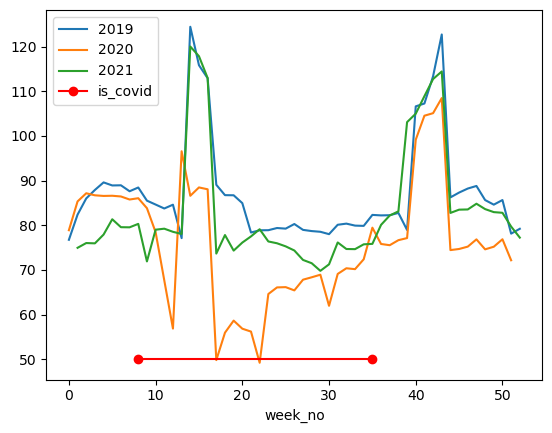

In [6]:
import datetime
import matplotlib.pyplot as plt
df_train['year_week'] = pd.to_datetime(df_train.year.astype(str) + df_train.week_no.astype(str) + '-1', format="%Y%W-%w")
df_train['is_covid'] = (df_train.year_week >= '2020-02-01')&(df_train.year_week < '2020-10-01')
df_train_year_week = df_train.groupby('year_week').mean()

ax = plt.axes()

for year in df_train.year.unique():
    df_train_year_week[df_train_year_week.year==year].set_index('week_no').emission.plot(ax=ax, legend=year)
ax.plot([8, 35], [50, 50], 'ro-')
ax.legend(list(df_train.year.unique())+['is_covid'])

# df_train_year_week[['year_week', 'emission']].plot()

In [7]:
from sklearn.metrics.pairwise import haversine_distances

worst_latlon = tuple(df_train[df_train.emission == df_train.emission.max()][['latitude', 'longitude']].iloc[0])
# print(df_train.columns)

def get_dist(X, Y):
    return haversine_distances([(X.latitude, X.longitude), Y])[0,1]

df_train['km_to_worst'] = df_train.apply(lambda x: get_dist(x, worst_latlon), axis=1)* 6371000/1000  # multiply by Earth radius to get kilometers

In [8]:
import geopandas as gpd
from shapely.geometry import Point

params ={
    'geometry': gpd.points_from_xy(df_train.longitude.astype(float), df_train.latitude.astype(float)),
    'crs': 'epsg:4326',  # WGS84
}

gdf_ = gpd.GeoDataFrame(df_train, **params)

<Axes: ylabel='Frequency'>

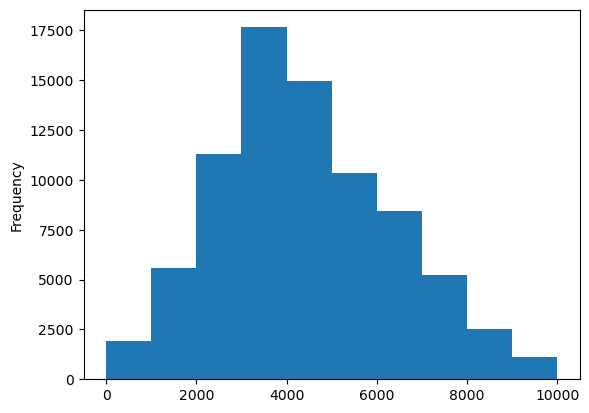

In [9]:
df_train['km_to_worst'].plot.hist()

In [10]:
gdf_[['geometry', 'emission', 'latitude', 'longitude', 'km_to_worst']].sample(n=1000).explore('km_to_worst', vmin=0, vmax=df_train.km_to_worst.max())

In [11]:
gdf_[['geometry', 'emission', 'latitude', 'longitude']].sample(n=1000).explore('emission', vmin=df_train.emission.quantile(0.001), vmax=df_train.emission.quantile(0.9))

In [12]:
df_train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,year_week,is_covid,km_to_worst
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994,2018-12-31,False,9994.799028
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176,2019-01-07,False,9994.799028
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381,2019-01-14,False,9994.799028
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286,2019-01-21,False,9994.799028
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317,2019-01-28,False,9994.799028


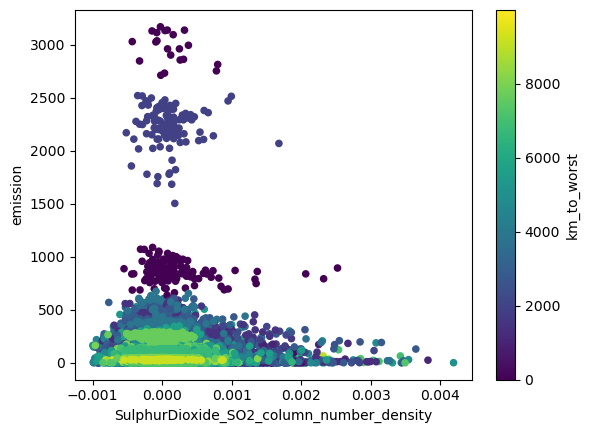

In [13]:
cols = ['SulphurDioxide_SO2_column_number_density']
for col in cols:
    df_train.plot.scatter(x=col, y='emission', c='km_to_worst')
    plt.show()

In [14]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'

class Learner:
    
    def __init__(
        self, 
        interactions=False, 
        scaler='minmax',
        features=None
    ):
        self.interactions = interactions
        self.scaler = None
        self.imputer = None
        
        if scaler == 'minmax':
            self.scaler = MinMaxScaler()
        elif scaler == 'box-cox':
            self.scaler = PowerTransformer(method='box-cox', standardize=False)
        elif scaler == 'yeo':
            self.scaler = PowerTransformer(method='yeo-johnson', standardize=False)
        elif scaler == 'quantile':
            self.scaler = QuantileTransformer(output_distribution='normal', random_state=0)
        elif scaler == 'standard':
            self.scaler = StandardScaler()
        elif scaler is None:
            self.scaler = None
        else:
            raise ValueError('provide a valid scaler')
            
        self.imputer = KNNImputer(n_neighbors=5, weights='uniform')
        self.rus = RandomUnderSampler(random_state=0)
        self.features = features
        self.worst_latlon = None
        self.clfs = [
            lgb.LGBMRegressor(
#                 boosting_type= 'gbdt',
#                 objective= 'binary',
#                 max_depth= 8,
#                 num_leaves= 10,
#                 bagging_fraction= 0.5,
#                 bagging_freq= 20,
#                 n_estimators=100,
                
#                 metric= 'auc',
#                 learning_rate= 0.03,
#                 feature_fraction= 0.7,
#                 n_jobs=5,
            ), 
#             MLPRegressor(
#                 solver='lbfgs', 
#                 alpha=0.01,
#                 hidden_layer_sizes=(8,),
#             ),
        ]
    
    def fit(self, X, y):
        self.worst_latlon = tuple(X[y == y.max()][['latitude', 'longitude']].iloc[0])
        X = self.preprocess(X, is_fitting=True)
        # X_resampled, y_resampled = self.rus.fit_resample(X, y)
        for i, clf in enumerate(self.clfs):
            if i == 0:
                X = pd.DataFrame(X, columns=self.features)
            clf.fit(X, y)
    
    def predict(self, X, threshold=1):
        X = self.preprocess(X)
        pred = np.stack([clf.predict(X) for clf in self.clfs])
        pred = np.mean(pred, axis=0)
        return pred
        
    def preprocess(self, X, is_fitting=False):
        n = len(X)
        
        X['year_week'] = pd.to_datetime(X.year.astype(str) + X.week_no.astype(str) + '-1', format="%Y%W-%w")
        X['month'] = X.year_week.dt.month
        X['km_to_worst'] = X.apply(lambda x: get_dist(x, self.worst_latlon), axis=1)*6371000/1000  # multiply by Earth radius to get kilometers

        if 'is_covid' not in X:
            X['is_covid'] = False
            
        if self.features is None:
            self.features = X.columns
        else:
            X = X[self.features]
            
        if is_fitting:
            pass
#             X = self.scaler.fit_transform(X)
#             X = self.imputer.fit_transform(X)
        else:
            pass
#             X = self.scaler.transform(X)
#             X = self.imputer.transform(X)
        assert len(X) == n
        return X
    

In [15]:
from sklearn.metrics import mean_squared_error

def RMSE(x, y):
    return np.sqrt(mean_squared_error(x, y))

def train(model, X, y, splits=10):
    
    if splits == 1:
        model.fit(X, y)
        y_pred = model.predict(X)
        m_loss = RMSE(y, y_pred)
        
        print(f'Model loss: {m_loss}')
        return model
    
    cv = KF(n_splits=splits, shuffle=True, random_state=42)
    min_loss = np.inf
    
    for train_idx, val_idx in tqdm(cv.split(X), total=splits):
        
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(x_train, y_train)
        
        y_pred = model.predict(x_val)
        m_loss = RMSE(y_val, y_pred)
        
        print(f'Model loss: {m_loss}')
        if m_loss < min_loss:
            best_model = model
            min_loss = m_loss
        
    return best_model

In [16]:
# df_train['rng'] = np.random.rand(len(df_train))
X = df_train #.drop(['ID_LAT_LON_YEAR_WEEK', 'emission', 'year_week', 'latitude', 'longitude'], axis=1)
y = df_train.emission

features = [col for col in df_train.columns if col not in ['emission_pred', 'ID_LAT_LON_YEAR_WEEK', 'emission', 'year_week', 'latitude', 'longitude']]
model = Learner(features=features)

In [17]:
model = train(model, X, y)

  0%|          | 0/10 [00:00<?, ?it/s]

Model loss: 65.72495823966004
Model loss: 75.41961200830461
Model loss: 85.61479640335969
Model loss: 63.925923565528805
Model loss: 75.40279451049005
Model loss: 72.8220482381494
Model loss: 85.15494097151306
Model loss: 65.53210578765653
Model loss: 83.4793381377151
Model loss: 77.27315366489461


In [18]:
# X = model.preprocess(X)
# pred = np.stack([clf.predict(X) for clf in model.clfs])
# pred = np.mean(pred, axis=0)
# pred
df_train['emission_pred'] = model.predict(X)

/tmp/ipykernel_20/3633226077.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_train_year_week = df_train.groupby('year_week').mean()


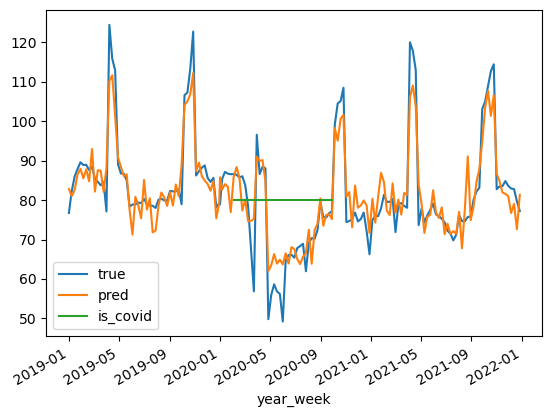

In [19]:
import datetime
import matplotlib.pyplot as plt
df_train_year_week = df_train.groupby('year_week').mean()

ax = plt.axes()

df_train_year_week.emission.plot(ax=ax)
df_train_year_week.emission_pred.plot(ax=ax)
df_train_year_week[df_train_year_week.is_covid==1].is_covid.mul(80).plot(ax=ax)

# ax.plot([8, 35], [50, 50], 'ro-')
ax.legend(['true', 'pred', 'is_covid'])

# df_train_year_week[['year_week', 'emission']].plot()

,Value,Feature
0,1313,km_to_worst
1,190,UvAerosolIndex_sensor_altitude
2,144,Cloud_surface_albedo
3,140,NitrogenDioxide_tropopause_pressure
4,94,CarbonMonoxide_H2O_column_number_density
...,...,...
69,0,UvAerosolLayerHeight_sensor_zenith_angle
70,0,UvAerosolLayerHeight_aerosol_optical_depth
71,0,UvAerosolLayerHeight_aerosol_pressure
72,0,UvAerosolLayerHeight_aerosol_height


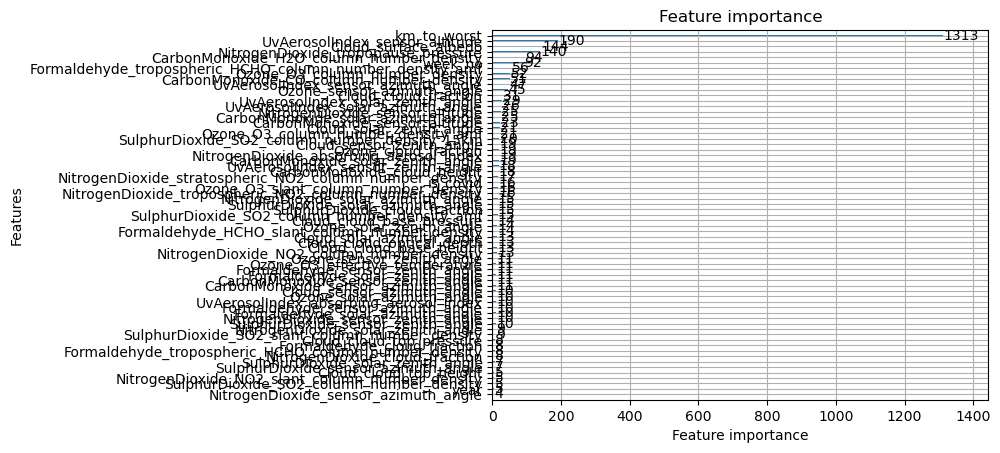

In [20]:
lgb.plot_importance(model.clfs[0])
df_feature_imp = pd.DataFrame({'Value':model.clfs[0].feature_importances_,'Feature':model.features}).sort_values(by="Value",ascending=False).reset_index(drop=True)
df_feature_imp

In [21]:
X_test = df_test
df_test['emission'] = model.predict(X_test)

In [22]:
df_out = df_test[['ID_LAT_LON_YEAR_WEEK', 'emission']]
df_out

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,19.393856
1,ID_-0.510_29.290_2022_01,14.414543
2,ID_-0.510_29.290_2022_02,9.643256
3,ID_-0.510_29.290_2022_03,14.694952
4,ID_-0.510_29.290_2022_04,18.102097
...,...,...
24348,ID_-3.299_30.301_2022_44,44.519870
24349,ID_-3.299_30.301_2022_45,27.712660
24350,ID_-3.299_30.301_2022_46,25.403813
24351,ID_-3.299_30.301_2022_47,30.440245


In [23]:
df_sample_sub

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,81.94
1,ID_-0.510_29.290_2022_01,81.94
2,ID_-0.510_29.290_2022_02,81.94
3,ID_-0.510_29.290_2022_03,81.94
4,ID_-0.510_29.290_2022_04,81.94
...,...,...
24348,ID_-3.299_30.301_2022_44,81.94
24349,ID_-3.299_30.301_2022_45,81.94
24350,ID_-3.299_30.301_2022_46,81.94
24351,ID_-3.299_30.301_2022_47,81.94


In [24]:
df_out.to_csv('submission.csv', index=False)